<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<div>HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.</div><br>
    <div>Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. </div><br>
     <div>Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.  </div>
    <ul>Задачи:
        <li> Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. </li>
        <li>вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.</li>
    </ul>
</div>

In [1]:
! pip install shap 
! pip install phik

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import shapiro
import seaborn as sns
import shap
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, make_scorer

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.neighbors  import KNeighborsRegressor, KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC

## Загрузка данных

In [3]:
try:
    data_train =  pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
except:
    data_train =  pd.read_csv('C:/projects/train_job_satisfaction_rate.csv')
data_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
try:
    data_test_X = pd.read_csv('/datasets/test_features.csv')
except:
    data_test_X = pd.read_csv('C:/projects/test_features.csv')
data_test_X.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [5]:
try:
    data_test_y = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    data_test_y = pd.read_csv('C:/projects/test_target_job_satisfaction_rate.csv')
data_test_y.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Загрузили данные, проверили корректность, приступаем к предобработке
</div>

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
data_train[data_train['dept'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [8]:
data_train[data_train['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [9]:
data_train.duplicated().sum()

0

In [10]:
data_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [11]:
data_train['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [12]:
data_train['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [13]:
data_train['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [14]:
data_train[data_train['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [15]:
data_train['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [16]:
data_train['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [17]:
data_train['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
\ проверили явные и неявные дубликаты, типы данных в норме, название столбцов тоже
</div>

In [18]:
data_test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [19]:
data_test_X.duplicated().sum()

0

In [20]:
data_test_X['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [21]:
data_test_X['dept'].fillna('NaN')

0        marketing
1               hr
2            sales
3            sales
4               hr
           ...    
1995     marketing
1996    technology
1997    technology
1998    technology
1999    purchasing
Name: dept, Length: 2000, dtype: object

In [22]:
data_test_X.loc[data_test_X['dept'] == ' ', 'dept'] = np.NaN

In [23]:
data_test_X['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [24]:
data_test_X['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [25]:
data_test_X['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [26]:
data_test_X.loc[data_test_X['workload'] == ' ', 'workload'] = np.NaN

In [27]:
data_test_X['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [28]:
data_test_X['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [29]:
data_test_y.duplicated().sum()

0

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
проверили явные и неявные дубликаты, типы данных в норме, название столбцов тоже
</div>

## Исследовательский анализ данных

In [30]:
def draw_grafic(columns,data):
    for i in columns:
        data[i].hist(bins=50, figsize=(10, 5), grid=True);
        plt.xlabel(i)
        plt.ylabel('Частота')
        plt.title(i)
        plt.show()
        data[i].plot(kind='box')
        plt.ylabel(i)
        plt.title(i)
        plt.show()
        stat, p_val = shapiro(data[i])
        if p_val < 0.5: print(i +' не нормальное')
        else: print(i +' нормальное')

In [31]:
data_train.describe(include = 'all').style.background_gradient('coolwarm')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,3994,3996,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000.000000
unique,nan,5,3,3,nan,2,2,nan,nan,nan
top,nan,sales,junior,medium,nan,no,no,nan,nan,nan
freq,nan,1512,1894,2066,nan,3880,3441,nan,nan,nan
mean,544957.621000,nan,nan,nan,3.718500,nan,nan,3.476500,33926.700000,0.533995
std,257883.104622,nan,nan,nan,2.542513,nan,nan,1.008812,14900.703838,0.225327
min,100954.000000,nan,nan,nan,1.000000,nan,nan,1.000000,12000.000000,0.030000
25%,322836.750000,nan,nan,nan,2.000000,nan,nan,3.000000,22800.000000,0.360000
50%,534082.500000,nan,nan,nan,3.000000,nan,nan,4.000000,30000.000000,0.560000
75%,771446.000000,nan,nan,nan,6.000000,nan,nan,4.000000,43200.000000,0.710000


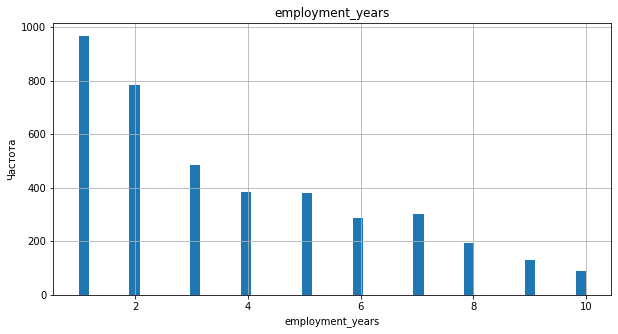

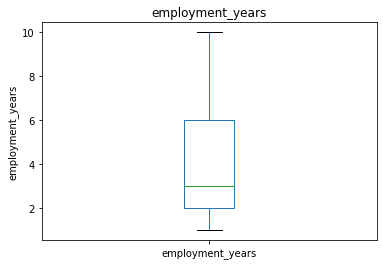

employment_years не нормальное


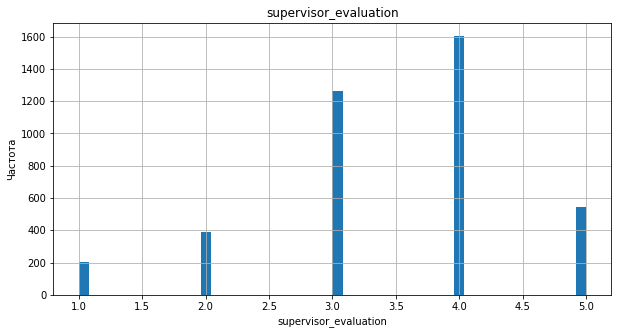

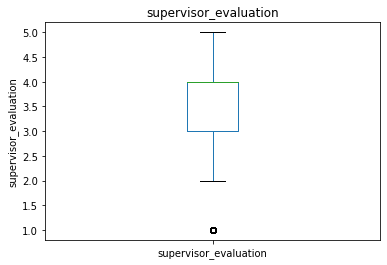

supervisor_evaluation не нормальное


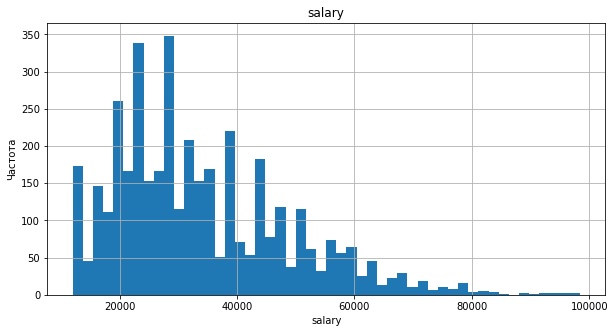

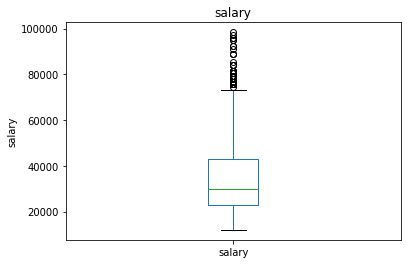

salary не нормальное


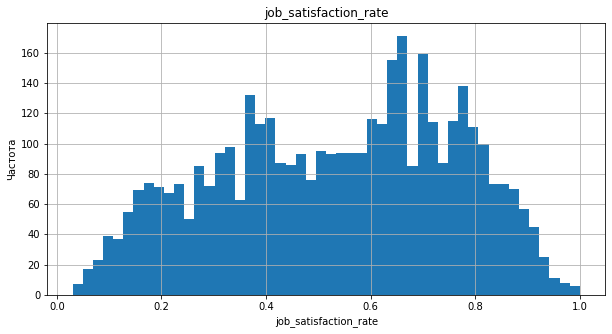

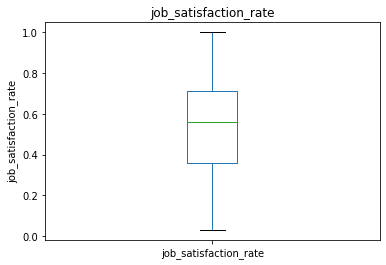

job_satisfaction_rate не нормальное


In [32]:
col = ['employment_years','supervisor_evaluation','salary','job_satisfaction_rate']
draw_grafic(col, data_train)

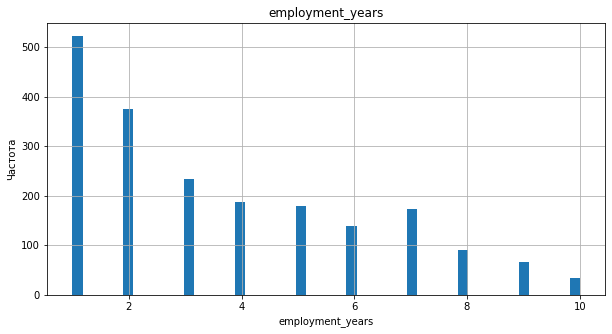

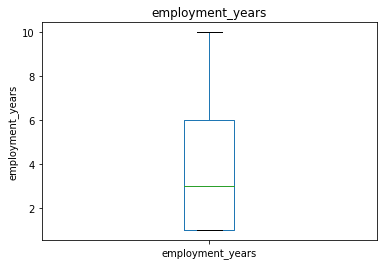

employment_years не нормальное


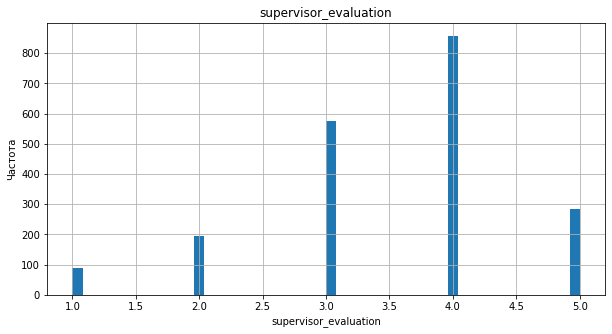

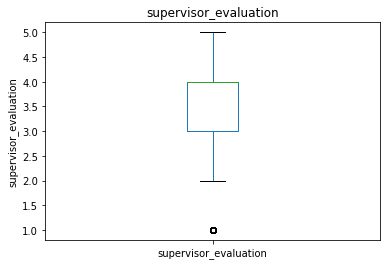

supervisor_evaluation не нормальное


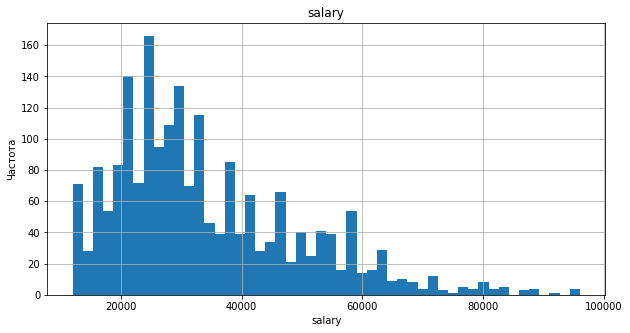

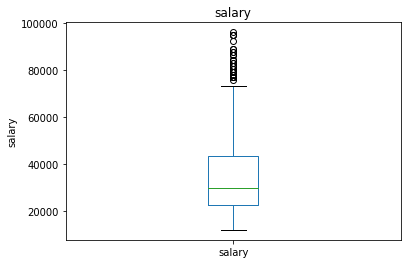

salary не нормальное


In [33]:
col = ['employment_years','supervisor_evaluation','salary']
draw_grafic(col, data_test_X)

In [ ]:
col = ['job_satisfaction_rate']
draw_grafic(col, data_test_y)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Везде наблюдаем ненормальное распределение без явных выбросов
</div>

In [ ]:
def draw_grafic_cat(columns,data):
    for i in columns:
        data[i].value_counts().plot(kind='bar',)
        plt.xlabel(i)
        plt.ylabel('Количество')
        plt.show()

In [ ]:
col = ['dept','level','workload','last_year_promo','last_year_violations']
draw_grafic_cat(col, data_train)

In [ ]:
col = ['dept','level','workload','last_year_promo','last_year_violations']
draw_grafic_cat(col, data_test_X)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
категориальные даныне так же впорядке, проблем нет, наблюдаются пропуски, которые будут устранены в пайплайне
</div>

In [ ]:
data_test = data_test_X.merge(data_test_y, on='id')

## Подготовка данных

In [ ]:
data_train.corr(method="spearman").style.background_gradient('coolwarm')

In [ ]:
data_test_X.corr(method="spearman").style.background_gradient('coolwarm')

In [ ]:
interval_cols = list(data_train.select_dtypes(['float','int']))

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = data_train.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

In [ ]:
interval_cols = list(data_test_X.select_dtypes(['float','int']))

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = data_test_X.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Проверили на корреляцию методом спирмена, мультикорреляции нет, можно переходить к постоению пайплайна
</div>

In [ ]:
data_train.head(5)

In [ ]:
#split_arr = np.array_split(data_train, 2)
#data_train_split = split_arr[1]

In [ ]:
#lab =LabelEncoder ()

In [ ]:
RANDOM_STATE = 42

X_train = data_train.drop(['job_satisfaction_rate','id'], axis=1)
X_test = data_test.drop(['job_satisfaction_rate','id'], axis=1)

y_test = data_test['job_satisfaction_rate']
y_train = data_train['job_satisfaction_rate']

#y_test = (lab.fit_transform(data_test['job_satisfaction_rate'])).round(0)
#y_train = (lab.fit_transform(data_train_split['job_satisfaction_rate'])).round(0)


#X_test = data_test_X.drop(['id','dept'],axis=1)
#y_test = (lab.fit_transform(data_test_y['job_satisfaction_rate']) / 10).round(0)

In [ ]:
#def smape(y_true, y_pred):
#    num = np.abs(y_true - y_pred)
#    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
#    
#    smape_value =  np.sum(num / dem) * (100.0 / len(y_true))
    
#    return smape_value
#score = make_scorer(smape) 

In [ ]:
def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
smape_scorer = make_scorer(smape, greater_is_better=False)

In [ ]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [ ]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

#num_pipe = Pipeline(
#    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='median')),
#     ('num', MinMaxScaler())
#    ]
#   )
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [ ]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE, max_features=11, min_samples_leaf=5)],
        'models__max_depth': range(15,20),
        'models__min_samples_split': range(10,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    #{
     #   'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, max_features=11, min_samples_leaf=5)],
      #  'models__max_depth': range(15,20),
       # 'models__min_samples_split': range(10,15),
       # 'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    #},
    #{
     #   'models': [KNeighborsClassifier()],
      #  'models__n_neighbors': range(2,5),
      #  #'models__weights': ['uniform', 'distance'],
      #  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    #},
    
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    #{
 #'models': [LogisticRegression( random_state=RANDOM_STATE,  solver='liblinear',  penalty='l1' )],
 #'models__C': range(1, 10), 
 #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
  #  },

]


In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,    
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:',-1*randomized_search.best_score_)

In [ ]:
y_test_pred = randomized_search.predict(X_test)

print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_test_pred)}')

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Построили пайплайн, отобрали 4 модели регрессии с гиперпараметрами, получили метрику smape на тестовой выборке 13.5, что подходит для нашего решения.
Так как в задаче просят оставить все модели, с которыми работали, закомментировал модели класификации, так как вначале использовал их, после анализа задачи, осознал, что задача регресии и сменил их.
Лучшая модель получилась дерево решений, ее логика хорошо подходит для задачи, она анализирует соседей, что для нашей задачи очень хорошо.
</div>

 # Задача 2: предсказание увольнения сотрудника из компании

# Шаг 1. Загрузка данных

In [ ]:
try:
    data_test_quit_y =  pd.read_csv('/datasets/test_target_quit.csv')
except:
    data_test_quit_y =  pd.read_csv(' C:/projects/test_target_quit.csv')
    
data_test_quit_y.head()

In [ ]:
data_test_quit_X = data_test_X
data_test_quit_X.head()

In [ ]:
try:
    data_quit_train = pd.read_csv('/datasets/train_quit.csv')
except:
    data_quit_train = pd.read_csv(' C:/projects/train_quit.csv')

data_quit_train.head()

# Шаг 2. Предобработка данных

In [ ]:
data_test_quit_y.info()

In [ ]:
data_quit_train.info()

In [ ]:
data_test_quit_y['quit'].unique()

In [ ]:
data_quit_train['dept'].unique()

In [ ]:
data_quit_train['level'].unique()

In [ ]:
data_quit_train['workload'].unique()

In [ ]:
data_quit_train['quit'].unique()

In [ ]:
data_quit_train['last_year_promo'].unique()

In [ ]:
data_quit_train['last_year_violations'].unique()

In [ ]:
data_quit_train.duplicated().sum()

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Проверили новые данные, типы корректные, пропусков и дубликатов нет, можно переходить к работе
</div>

In [ ]:
#data_quit_train
#data_test_quit_y

# Шаг 3. Исследовательский анализ данных

In [ ]:
col = ['dept','level','workload','last_year_promo','last_year_violations','quit']
draw_grafic_cat(col, data_quit_train)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Информационные графики по всем работникам по категориальным признакам, там видим самые распространненые должности/уровень/нагрузку
</div>

In [ ]:
col = ['dept','level','workload','last_year_promo','last_year_violations']
draw_grafic_cat(col, data_quit_train[data_quit_train['quit']=='yes'])

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Информационные графики по всем уволившимся сотруднкиам по категориальным признакам, первый вывод, который можно сделать, что больше всего увольняется новичков с маленькой нагрузкой, можно сделать вывод, что устраивались только ради получения какого-то опыта, т.е. не было серьезных намерений 
</div>

In [ ]:
data_quit_train.groupby('quit')['salary'].plot(kind='kde')
plt.xlabel('Зарплата')
plt.legend(['no', 'yes'], title='Quit')
plt.show()

In [ ]:
data_quit_train.groupby('quit')['salary'].hist(bins=30)
plt.xlabel('Зарплата')
plt.legend(['no', 'yes'], title='Quit')
plt.ylabel('Количество cотрудников')
plt.show()

In [ ]:
data_quit_train.groupby('quit')['salary'].mean()

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Сотрудники с высоокой зарплатой увольняются намного реже, чем в маленькой. Средняя зарплата для ушедших 23885, для тех кто остался 37702
</div>

In [ ]:
data_quit_train.groupby('quit')['dept'].hist(legend= True)
plt.xlabel('Отдел')
plt.ylabel('Количество cотрудников')
plt.title('График отношения уволившихся к оставшимся')
plt.show()

In [ ]:
data_quit_train['dept'].hist()
data_quit_train[data_quit_train['quit'] == 'yes']['dept'].hist(legend= True)
plt.xlabel('Отдел')
plt.ylabel('Количество cотрудников')
plt.title('График отношения уволившихся ко всем')


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
# 2 доработка <br>
Постороили два доп.графика, отношение уволившихся ко всем и уволившихся к оставшимся, по ним видим:
    <ul>График отношения уволившихся к оставшимся
       <li>в sales - 1 к 2.5</li>
        <li>в purchasing - 1 к 5.25 </li>
        <li>в marketing - такие же показатели, как в purchasing</li>
        <li>в technology - 1 к 2.6</li>
        <li>в hr - показатели 1 к 6</li>
    </ul>
    <ul> График отношения уволившихся ко всем
        <li>в sales - 1 к 3.5</li>
        <li>в purchasing - примерно 30%, что означает 3 к 10 </li>
        <li>в marketing - такие же показатели, как в purchasing</li>
        <li>в technology - 28%, что 1 к 3.5</li>
        <li>в hr - показатели 1 к 7</li>
    </ul>
</div>

In [ ]:
data_test_quit_y.head()

In [ ]:
data_test_y.head()

In [ ]:
data_check_rate = data_test_y.merge(data_test_quit_y, on='id')
data_check_rate

In [ ]:
data_check_rate.groupby('quit')['job_satisfaction_rate'].plot(kind='kde')
plt.xlabel('Уровень удовлетворенности')
plt.legend(['no', 'yes'], title='Quit')
plt.show()

In [ ]:
data_check_rate.groupby('quit')['job_satisfaction_rate'].hist(bins=30)
plt.xlabel('Уровень удовлетворенности')
plt.legend(['no', 'yes'], title='Quit')
plt.show()

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
У уволившихся сотрудников уровень удовлетворенности действительно меньше
</div>

# Шаг 4. Добавление нового входного признака

In [ ]:
data_quit_train_added = data_quit_train.drop(['id', 'quit'], axis=1) 
data_quit_train_added.head()

In [ ]:
rate_added = randomized_search.best_estimator_.predict(data_quit_train_added).round(2)

In [ ]:
data_quit_train_added = pd.concat([data_quit_train_added, pd.DataFrame(rate_added)], axis=1) 
data_quit_train_added.head()

In [ ]:
data_quit_train_added.columns = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
 'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 
data_quit_train_added.head()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Хорошо, признак job_satisfaction_rate добавлен в тренировочную и тестовую выборки, а значения предсказаны с помощью лучшей модели регрессии, обученной в прошлой части задачи

# Шаг 5. Подготовка данных

In [ ]:
data_test_2 = data_test.merge(data_test_quit_y, on='id')
data_test_2

In [ ]:
X_train_quit = data_quit_train_added
X_test_quit = data_test_2.drop(['quit','id'], axis=1)

y_train_quit = data_quit_train['quit']
y_test_quit = data_test_2['quit']

In [ ]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload'] 
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

In [ ]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [ ]:
param_grid_2 = [ 
    {
 'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, min_samples_split=13, max_features=10)], 
 'models__max_depth': range(13,18), 
 'models__min_samples_leaf': range(13,18),  
 'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
 
    {
 'models': [KNeighborsClassifier()], 
 'models__n_neighbors': range(2, 11), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
 
    {
 'models': [LogisticRegression( random_state=RANDOM_STATE,  solver='liblinear',  penalty='l1' )],
 'models__C': range(1, 10), 
 'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
 
]

# Шаг 6. Обучение модели

In [ ]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final, 
    param_grid_2, 
    cv=5,
    scoring='roc_auc',    
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50
)
randomized_search_2.fit(X_train_quit, y_train_quit)
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:',randomized_search_2.best_score_)

In [ ]:
y_test_pred2 = randomized_search_2.predict_proba(X_test_quit) 

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_quit, y_test_pred2[:,1])}') 

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Построили пайплайн для второй задачи, использовали модели классификации, получили необходимый результа, лучшей оказалась Дерево Решений с показателем на тестовой выборке 0.92
</div>

# Шаг 7. Выводы

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Наш проект подходит к завершению, в его рамках произведен анализ данных, постоены 2 пайплайна для разных задач.
 <br>
Как мне кажется обе модели показали себя хорошо, если отдавать какой-то предпочтение, то вторая справилась лучше, так как у нее есть дополнительный отличный признак, который был получен в рамках первой модели.
<br>
Т.е. качественная работа первой модели сделала вторую модель лучше, так же результат работы моделей классификаций легче оценивать, как мне кажется :)
</div>

# Общий вывод


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    <ul><div>HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.</div><br>
    <div>Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. </div><br>
     <div>Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.  </div><br><br></ul>
    <div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    <ul>В начале я загрузил наш входной набор данных из 3 таблиц для первой задачи(задачи регрессии), проверили качество данных, провели их предобработку, иследовательский анализ, проверили корреляцию, проверили распрелеление данных</ul>
    <ul>Следующим шагом построение пайплайна для первой задачи, отобрали модели, гиперпараметры, построили функцию для метрики SMAPE, после чего нашли лучшую модель с необходимой метрикой</ul>
    <ul>Далее мы перешли ко второй задаче, провели такие что процедуры с входными данными, добавили новый столбец на основе работы первой модели </ul>
    <ul>И перешли к постоению второго пайплайна для с моделями классификации</ul>
   
   